In [1]:
# import packages

import pickle, pprint
import numpy as np

In [2]:
# load data

pkl_file = open('zo1_graph_timelapse_sample_v2.pkl','rb')
data1 = pickle.load(pkl_file)

# Data Visualization

In [3]:
# choose time step
# 12, 13 seems difficult
# couple of difficult ones. Need to rethink how to go about this
t = 10

Number of branches is  68
Number of nodes is  136


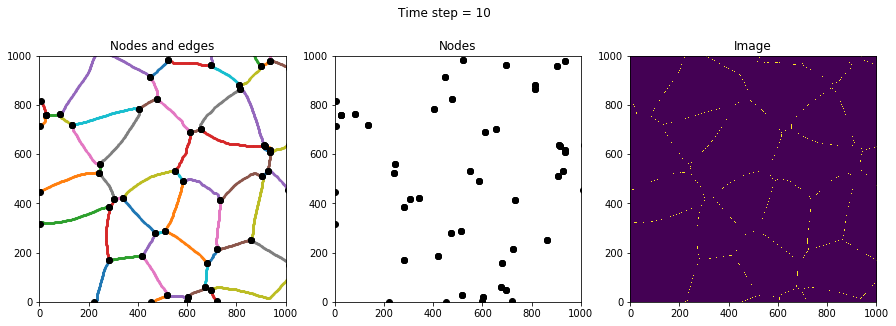

In [4]:
# plot edge, node and image data at time step t

import matplotlib
import matplotlib.pyplot as plt
from scipy import ndimage

%matplotlib inline
fig, (ax, ax2, ax3) = plt.subplots(1,3, figsize = (15,5))

# plot nodes and edges
posit = [i for i in range(len(data1[2][t]))]

for pos in posit:
    l = len(data1[2][t][pos][:])-1
    # all edges/branches
    ax.plot(data1[1][t][data1[2][t][pos][:],1], data1[1][t][data1[2][t][pos][:],0],'.', markersize = 2)
    
    # nodes (endpoints)
    ax.plot(data1[1][t][data1[2][t][pos][0],1], data1[1][t][data1[2][t][pos][0],0], 'ok')
    ax.plot(data1[1][t][data1[2][t][pos][l],1], data1[1][t][data1[2][t][pos][l],0], 'ok')

# plot nodes
for pos in posit:
    l = len(data1[2][t][pos][:])-1
    ax2.plot(data1[1][t][data1[2][t][pos][0],1], data1[1][t][data1[2][t][pos][0],0],'ok')
    ax2.plot(data1[1][t][data1[2][t][pos][l],1], data1[1][t][data1[2][t][pos][l],0],'ok')

# plot image
img = ndimage.rotate(data1[0][t] == 2, 0)
# plot the image with origin at lower left
ax3.imshow(img, origin = 'lower')

titles = ['Nodes and edges','Nodes', 'Image' ]
# axis stuff
axes = list([ax, ax2, ax3])
for j,ax in enumerate(axes):
    ax.set(xlim = [0,1000], ylim = [0,1000], aspect = 1)
    ax.set_title(titles[j])

fig.suptitle("Time step = %d" %t , fontsize=12)
print('Number of branches is ', len(posit))
print('Number of nodes is ', 2*len(posit))

# Curve fitting + Data post processing

Now we put the nodes and edges into our data structure and perform curve fits to find radius

Theres a lot of nodes stacked on top of each other. We have to group nodes together if they are really really close

What we do here is check the normalized distance of a node from all the other nodes in a list that we are constantly appending. If the distance is more than a cutoff, then we make a new node. If its less than a cutoff, then we replace that node with the closest node to it in the list. 

We only add a new branch if the node_a and node_b selected after the above process for a branch are not the same

In [5]:
# choose cutoff distance (minimum normalized distance between nodes)
# change this value if error -> impossible arc asked for, radius too small

cutoff = 5

In [6]:
# put data into node and edge classes and perform curve fitting

import sys
sys.path.insert(0, '../cell_soap/')
from cell_describe import node, edge
from fitting import fit

# posit is the list of branches
posit = [i for i in range(len(data1[2][t]))]

#list of nodes and edges to be updated
nodes, edges = [], []

for pos in posit:
    # l is the index of the last point on a branch
    l = len(data1[2][t][pos][:])-1
    
    ###################################################
    # define node class
    # check if radius is 0
    
    # node_a is the node at location 0 of a branch
    node_a = node((data1[1][t][data1[2][t][pos][0],1], data1[1][t][data1[2][t][pos][0],0]))
    
    # check if nodes list is empty
    dist = []
    for n in nodes:
        dist.append(np.linalg.norm(np.subtract(n.loc, node_a.loc)))
    
    # lets choose a cutoff pixel norm distance of 100 
    # if the distance between node_a and all nodes in list is more than

    if not dist:
        nodes.append(node_a)
    else:  
        if all(i >= cutoff for i in dist):
            nodes.append(node_a)          
        else:
            ind = dist.index(min(dist))
            node_a = nodes[ind]

    # node_b is the node at location l (last) of a branch
    node_b = node((data1[1][t][data1[2][t][pos][l],1], data1[1][t][data1[2][t][pos][l],0]))
    

    # check if nodes list is empty

    dist = []
    for n in nodes:
        dist.append(np.linalg.norm(np.subtract(n.loc, node_b.loc)))
    
    # lets choose a cutoff pixel norm distance of 100
    
    # if the distance between node_b and all nodes in list is more than 
    if not dist:
        nodes.append(node_b)
    else:  
        if all(i >= cutoff for i in dist):
            nodes.append(node_b)          
        else:
            ind = dist.index(min(dist))
            node_b = nodes[ind] 
        
    ###################################################
    # calculate radius for curve fitting
    
    # only do fit and add edge if the 2 nodes are not the same
    if node_a.loc != node_b.loc:
    
        # x and y are co-ordinates along a branch (dataset). 
        x = data1[1][t][data1[2][t][pos][:],1]
        y = data1[1][t][data1[2][t][pos][:],0]

        # we want to fit a curve to this. Use least squares fitting.
        # output is radius and x,y co-ordinates of the centre of circle
        radius, xc, yc = fit(x,y)

        # Check the direction of the curve. Do this by performing cross product 
        x1, y1, x2, y2 = x[0], y[0], x[-1], y[-1]
        v1 = [x1 - xc, y1 - yc]
        v2 = [x2 - xc, y2 - yc]
        cr = np.cross(v1, v2)
        a = 0.5*np.linalg.norm(np.subtract([x2,y2], [x1,y1])) # dist to midpoint
        ###################################################
        # define edge class
        # check if radius is 0
        if radius > 0:
            # same assertion thats in the class
            if a < radius:
                # if cross product is negative, then we want to go from node_a to node_b
                # if positive, we want to go from node_b to node_a
                if cr > 0:
                    ed = edge(node_b, node_a, radius)
                    #ed = edge(node_b, node_a, radius, xc, yc)
                else:
                    ed = edge(node_a, node_b, radius)
                    #ed = edge(node_a, node_b, radius, xc, yc)
        else:
            # if no radius, leave as None
            ed = edge(node_a, node_b, None, None, None)
        edges.append(ed)

Now we have a list of nodes and edges. Lets plot them and original data to see if the curve fit is working


Number of branches is  67
Number of nodes is  56


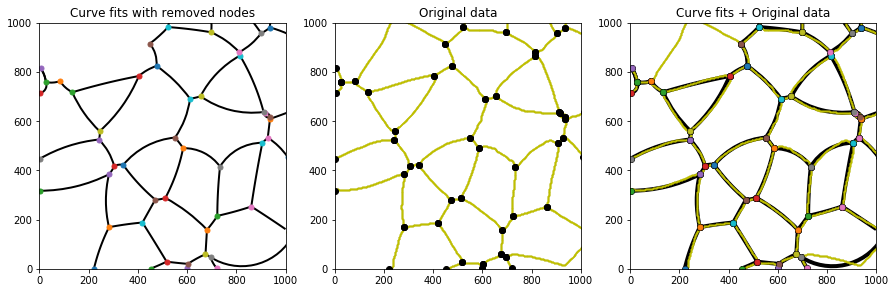

In [7]:
# check edge and node plots from class

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
fig, (ax, ax1, ax2) = plt.subplots(1,3, figsize = (15,5))

[n.plot(ax, lw = 2) for n in edges]
[n.plot(ax, markersize = 10) for n in nodes]
ax.set(xlim = [0,1000], ylim = [0,1000], aspect = 1)


for aa in [ax1,ax2]:
    for pos in posit:
        l = len(data1[2][t][pos][:])-1
        # all edges/branches
        aa.plot(data1[1][t][data1[2][t][pos][:],1], data1[1][t][data1[2][t][pos][:],0],'.',color = 'y', markersize = 1)

        # nodes (endpoints)
        aa.plot(data1[1][t][data1[2][t][pos][0],1], data1[1][t][data1[2][t][pos][0],0], 'ok')
        aa.plot(data1[1][t][data1[2][t][pos][l],1], data1[1][t][data1[2][t][pos][l],0], 'ok')
        
[n.plot(ax2, lw = 4) for n in edges]
[n.plot(ax2, markersize = 10) for n in nodes]
ax2.set(xlim = [0,1000], ylim = [0,1000], aspect = 1)
        
ax1.set(xlim = [0,1000], ylim = [0,1000], aspect = 1)
ax1.set_title('Original data')
ax.set_title('Curve fits with removed nodes')
ax2.set_title('Curve fits + Original data')
print('Number of branches is ', len(edges))
print('Number of nodes is ', len(nodes))

Potentially do more post processing here because it seems to run ito problems curve fitting stuff for larger cutoffs

Need to check that a node is connected to only 2 edges. In which case, delete it and replace the 2 edges with one edge

First, we check for nodes that are connected to a single edge with length less than a cutoff and delete them

In [8]:
# Seems like theres a few nodes that are connected to a single edge with a length smaller than a cutoff
# Lets do another round of processing to eliminate this

# Cutoff length to ignore edges connected a single node
cutoff2 = 50
ind_node, ind_edge = [], []

for n in nodes:
    if len(n.edges) == 1:
        e = n.edges[0]
        if e.straight_length < cutoff2:
            ind_node.append(nodes.index(n))
            ind_edge.append(edges.index(e))
            
            # Delete this edge and associated tension vector from the other node
            other_node = e.nodes.difference([n]).pop()
            
            other_node.tension_vectors.pop(other_node.edges.index(e))
            other_node.edges.remove(e)

# Delete all the bad nodes 
print('Before')
print('Number of branches is ', len(edges))
print('Number of nodes is ', len(nodes))

for index in sorted(ind_node, reverse=True):
    del nodes[index]
    
# Delete all the bad edges
for index in sorted(ind_edge, reverse=True):
    del edges[index]

print('After')
print('Number of branches is ', len(edges))
print('Number of nodes is ', len(nodes)) 

Before
Number of branches is  67
Number of nodes is  56
After
Number of branches is  62
Number of nodes is  51


Plot to check

Number of branches is  62
Number of nodes is  51


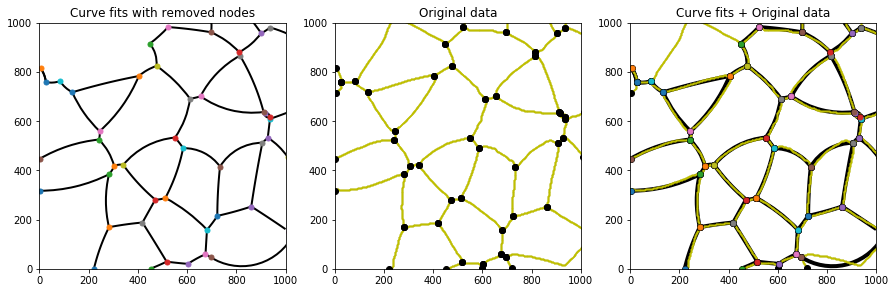

In [9]:
# check edge and node plots from class

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
fig, (ax, ax1, ax2) = plt.subplots(1,3, figsize = (15,5))

[n.plot(ax, lw = 2) for n in edges]
[n.plot(ax, markersize = 10) for n in nodes]
ax.set(xlim = [0,1000], ylim = [0,1000], aspect = 1)


for aa in [ax1,ax2]:
    for pos in posit:
        l = len(data1[2][t][pos][:])-1
        # all edges/branches
        aa.plot(data1[1][t][data1[2][t][pos][:],1], data1[1][t][data1[2][t][pos][:],0],'.',color = 'y', markersize = 1)

        # nodes (endpoints)
        aa.plot(data1[1][t][data1[2][t][pos][0],1], data1[1][t][data1[2][t][pos][0],0], 'ok')
        aa.plot(data1[1][t][data1[2][t][pos][l],1], data1[1][t][data1[2][t][pos][l],0], 'ok')
        
[n.plot(ax2, lw = 4) for n in edges]
[n.plot(ax2, markersize = 10) for n in nodes]
ax2.set(xlim = [0,1000], ylim = [0,1000], aspect = 1)
        
ax1.set(xlim = [0,1000], ylim = [0,1000], aspect = 1)
ax1.set_title('Original data')
ax.set_title('Curve fits with removed nodes')
ax2.set_title('Curve fits + Original data')
print('Number of branches is ', len(edges))
print('Number of nodes is ', len(nodes))

Next we make sure there are only triple junctions or higher -> meaning no double junctions

In [14]:
# Make sure theres no double junction, only triple or higher

ind, ind_edge = [], []
new_edges = []

for n in nodes:
    if len(n.edges) == 2:
        
        # Get the index of the node to be deleted later
        ind.append(nodes.index(n))
        # Get the 2 edges associated with this node
        edge1 = n.edges[0]
        edge2 = n.edges[1]
        print(n.edges)
        
        
        # Get the indices of the 2 edges to be deleted later
        ind_edge.append(edges.index(edge1))
        ind_edge.append(edges.index(edge2))
        print(ind_edge)
        
        # Get the non-common nodes of the 2 edges that become node_a and node_b
        node_a = edge1.nodes.difference([n]).pop()
        node_b = edge2.nodes.difference([n]).pop()
        
        # Dont want to define a new node since this node already exists in the list
        node_a = [n for n in nodes if n.loc == node_a.loc][0]
        node_b = [n for n in nodes if n.loc == node_b.loc][0]
    

                
        # Define a new radius
        new_rad = (edge1.radius + edge2.radius)/2
        
        # add a new edge with new nodes and new radius
        new_edge = edge(node_a, node_b, new_rad)
        new_edges.append(new_edge)
        
# Delete all the bad nodes
print('Before')
print('Number of branches is ', len(edges))
print('Number of nodes is ', len(nodes))

for i in ind:
    n = nodes[i]
    edge1 = n.edges[0]
    edge2 = n.edges[1]
    node_a = edge1.nodes.difference([n]).pop()
    node_b = edge2.nodes.difference([n]).pop()
    
    try:
        # Delete edge1 and edge2 from the list of edges connected to node_a and node_b respectively
        node_a.tension_vectors.pop(node_a.edges.index(edge1))
        node_b.tension_vectors.pop(node_b.edges.index(edge2))
        node_a.edges.remove(edge1)
        node_b.edges.remove(edge2)
    except:
        pass

for index in sorted(ind, reverse=True):
    del nodes[index]
    
# Delete all the bad edges
for index in sorted(ind_edge, reverse=True):
    del edges[index]

# Add all new adges
for e in new_edges:
    edges.append(e)

print('After')
print('Number of branches is ', len(edges))
print('Number of nodes is ', len(nodes))
        
        

[<cell_describe.edge object at 0x1332aa8f60>, <cell_describe.edge object at 0x1332685208>]


ValueError: <cell_describe.edge object at 0x1332aa8f60> is not in list

In [15]:
print([len(n.edges) for n in nodes])

[1, 3, 1, 5, 7, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 1, 3, 3, 3, 3, 1, 3, 3, 1, 3, 4, 3, 1, 3, 3, 3, 3, 3, 4, 3, 1, 3, 4, 3, 3, 1, 1, 2]


In [12]:
[n for n in nodes if n.loc == node_a.loc][0]
node_a

Plot it again

Number of branches is  57
Number of nodes is  46


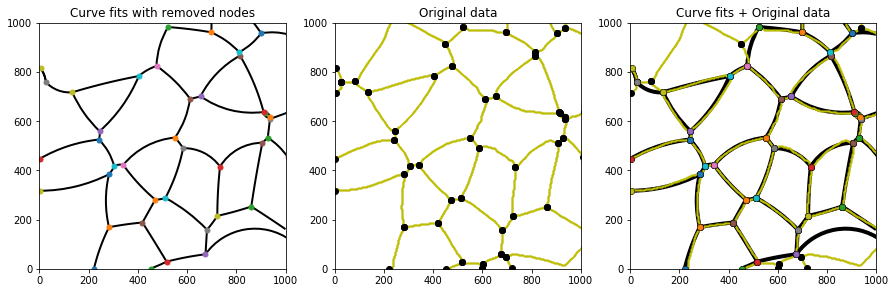

In [16]:
# check edge and node plots from class

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
fig, (ax, ax1, ax2) = plt.subplots(1,3, figsize = (15,5))

[n.plot(ax, lw = 2) for n in edges]
[n.plot(ax, markersize = 10) for n in nodes]
ax.set(xlim = [0,1000], ylim = [0,1000], aspect = 1)


for aa in [ax1,ax2]:
    for pos in posit:
        l = len(data1[2][t][pos][:])-1
        # all edges/branches
        aa.plot(data1[1][t][data1[2][t][pos][:],1], data1[1][t][data1[2][t][pos][:],0],'.',color = 'y', markersize = 1)

        # nodes (endpoints)
        aa.plot(data1[1][t][data1[2][t][pos][0],1], data1[1][t][data1[2][t][pos][0],0], 'ok')
        aa.plot(data1[1][t][data1[2][t][pos][l],1], data1[1][t][data1[2][t][pos][l],0], 'ok')
        
[n.plot(ax2, lw = 4) for n in edges]
[n.plot(ax2, markersize = 10) for n in nodes]
ax2.set(xlim = [0,1000], ylim = [0,1000], aspect = 1)
        
ax1.set(xlim = [0,1000], ylim = [0,1000], aspect = 1)
ax1.set_title('Original data')
ax.set_title('Curve fits with removed nodes')
ax2.set_title('Curve fits + Original data')
print('Number of branches is ', len(edges))
print('Number of nodes is ', len(nodes))

[(400, 700), (600, 800), None]

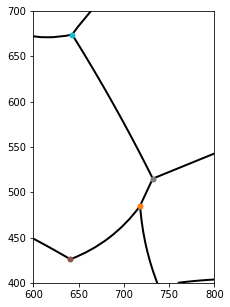

In [14]:
# Zoom into problematic parts if need be

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
fig, ax = plt.subplots(1,1, figsize = (5,5))

[n.plot(ax, lw = 2) for n in edges]
[n.plot(ax, markersize = 10) for n in nodes]
ax.set(xlim = [600,800], ylim = [400,700], aspect = 1)

This feels like as much cleaning up as possible. We first removed all overlapping nodes, then removed nodes connected to single edge of very small length, then removed nodes connected to 2 edges and we are left with a set of TJ or more with approximate curve fits

# Cell finding

Next we look for cells

In [15]:
# Perform cell finding code. Output is cells
#type specifies direction of cell finding. 0 for minimum positive angle and 1 for maximum negative angle
# both types are implemented
# num specifies the final node (node_b if we start from node_a)
from main import main

type = 0
num = 1
cells = []

for ed in edges:
    con_edges0 = ed.connected_edges[0]
    angles1 = [ed.edge_angle(e2)  for e2 in con_edges0]
    cells = main(ed, angles1, con_edges0, cells, type, num)
    type = 1
    cells = main(ed, angles1, con_edges0, cells, type, num)

Lets plot the cells to see that it found something

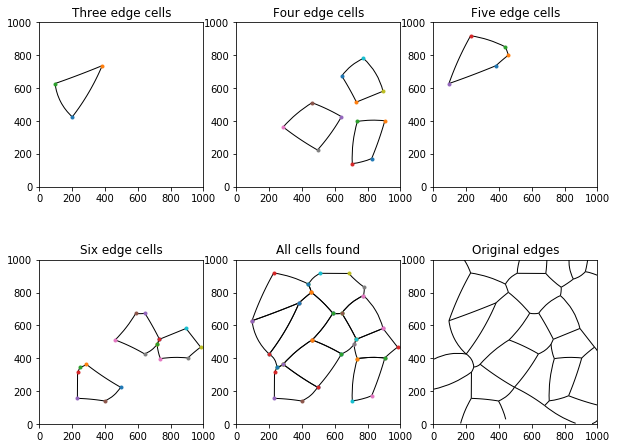

In [16]:
# plot all cells

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
fig, axes = plt.subplots(2,3,figsize=(10,8))
[cell.plot(axes[0, 0]) for cell in cells if len(cell.edges) == 3];
[cell.plot(axes[0, 1]) for cell in cells if len(cell.edges) == 4];
[cell.plot(axes[0,2]) for cell in cells if len(cell.edges) == 5];
[cell.plot(axes[1,0]) for cell in cells if len(cell.edges) == 6];
[cell.plot(axes[1,1]) for cell in cells if len(cell.edges) == 3 or 4 or 5 or 6 or 7 or 8 or 9 or 10 ];
#[cell.plot(axes[2,1]) for cell in cell_seven];
[ed.plot(axes[1,2]) for ed in edges];

[a.set(xlim=(0,1000), ylim=(0, 1000), aspect=1) for a in axes[1,:]]
[a.set(xlim=(0,1000), ylim=(0, 1000), aspect=1) for a in axes[0,:]]
#[a.set(xlim=(-1,1), ylim=(-1, 1), aspect=1) for a in axes[2,:]]
axes[1,2].set_title("Original edges")
axes[0,0].set_title("Three edge cells")
axes[0,1].set_title("Four edge cells")
axes[0,2].set_title("Five edge cells")
axes[1,0].set_title("Six edge cells")
#axes[2,1].set_title("Seven edge cells")
axes[1,1].set_title("All cells found")
plt.show()

Sometimes i see that the code misses a cell. Need to figure out why

# Tension and pressure calculation

Now that the cells are sorted, we define a colony and calculate tension

In [17]:
# Define colony and calculate tension. Then use that to find pressure

from cell_describe import colony 

col1 = colony(cells, edges, nodes)





In [18]:
# A and B are the matrices. Tensions and pressures are values for each edge and cell respectively 

tensions, A, U, S, V = col1.calculate_tension()

pressures, B, rhs = col1.calculate_pressure(tensions)

In [19]:
len(col1.edges)
print(np.shape(A))
print(len(col1.nodes))
print(len(col1.tot_edges))
print(len(col1.edges))
print(len(col1.tot_nodes))
print(len(cells))

(62, 55)
28
55
37
46
10


In [20]:
print([len(n.edges)>2 for n in nodes])
len([len(n.edges) for n in nodes])

[False, False, False, True, False, False, True, True, True, True, True, True, True, False, True, True, True, False, True, True, True, True, True, False, True, True, False, True, True, True, True, True, True, True, True, True, True, True, True, True, False, False, False, False, False, False]


46

In [25]:
np.shape(S)
np.shape(S)
S


array([2.06047056e+00, 2.05348452e+00, 1.94951872e+00, 1.91466095e+00,
       1.88591244e+00, 1.88149194e+00, 1.88114474e+00, 1.82376945e+00,
       1.82144107e+00, 1.81540646e+00, 1.77322866e+00, 1.76221246e+00,
       1.74516921e+00, 1.70538052e+00, 1.61497492e+00, 1.60840152e+00,
       1.59599384e+00, 1.55887831e+00, 1.54028443e+00, 1.50672685e+00,
       1.47278586e+00, 1.43568830e+00, 1.41188770e+00, 1.32689849e+00,
       1.31186720e+00, 1.25060425e+00, 1.24789879e+00, 1.23757290e+00,
       1.22237391e+00, 1.16918497e+00, 1.13562271e+00, 1.10124929e+00,
       1.05917561e+00, 1.02746151e+00, 9.90660347e-01, 9.81442671e-01,
       9.70807286e-01, 9.69464149e-01, 9.25099255e-01, 8.37525536e-01,
       8.24003940e-01, 7.72481053e-01, 7.12423121e-01, 6.61912806e-01,
       6.42636859e-01, 5.73812018e-01, 5.61720233e-01, 4.91053225e-01,
       4.39140715e-01, 4.14799637e-01, 3.87108164e-01, 3.42730522e-01,
       1.90965382e-01, 7.02453420e-02, 1.09444392e-16])

In [22]:
print(pressures)

[-2.01975579e-17 -2.66661857e-18 -6.48639569e-18  7.13759851e-18
 -2.39086894e-18 -3.54744825e-18  8.28162767e-18 -7.40535003e-19
  1.06342138e-17  9.97598435e-18]


Text(0.5,1,'Colony at time -> 18')

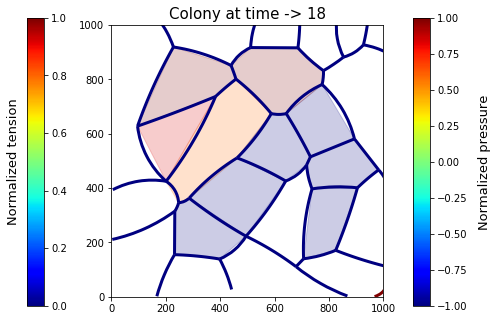

In [23]:
# plot tension and pressures on a single plot

import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
from matplotlib.colors import Normalize
import matplotlib as mpl

# Get edges from colony
edges2 = col1.tot_edges
nodes2 = col1.nodes
# edges2 = edges
# nodes2 = nodes
fig, ax = plt.subplots(1,1,figsize=(8,5))


# Normalize pressures and tensions

min_t = min(tensions)
max_t = max(tensions)

def norm(tensions):
    return (tensions - min_t) / float(max_t - min_t)
#return (tensions - np.mean(tensions))/float(np.std(tensions))

new = norm(tensions)

min_p = min(pressures)
max_p = max(pressures)

def norm(pressures):
    #return (pressures - min_p) / float(max_p - min_p)
    return (pressures - np.mean(pressures))/float(np.std(pressures))

new2 = norm(pressures)

# Plot pressures

for j, c in enumerate(cells):
    x = [n.loc[0] for n in c.nodes]
    y = [n.loc[1] for n in c.nodes]
    plt.fill(x, y, c= cm.jet(new2[j]), alpha = 0.2)

sm = plt.cm.ScalarMappable(cmap=cm.jet, norm=plt.Normalize(vmin=-1, vmax=1))
# fake up the array of the scalar mappable. 
sm._A = []

cbaxes = fig.add_axes([0.8, 0.1, 0.03, 0.8])
cl = plt.colorbar(sm, cax = cbaxes)  
cl.set_label('Normalized pressure', fontsize = 13, labelpad = 10)

# Plot tensions

for j, an_edge in enumerate(edges2):
    an_edge.plot(ax, edgecolor = cm.jet(new[j]), lw = 3)

sm = plt.cm.ScalarMappable(cmap=cm.jet, norm=plt.Normalize(vmin=0, vmax=1))
# fake up the array of the scalar mappable. 
sm._A = []

cbaxes = fig.add_axes([0.13, 0.1, 0.03, 0.8])
cl = plt.colorbar(sm, cax = cbaxes)
cl.set_label('Normalized tension', fontsize = 13, labelpad = -60)

ax.set(xlim=[0,1000], ylim=[0, 1000], aspect = 1)
ax.set_title('Colony at time -> %d' %t, fontsize = 15)





# Check condition numbers

Lets check the condition numbers of matrix A (for tension) and matrix B (for pressure)

In [17]:
# Condition numbers for the tension matrix 

from numpy import linalg as la

# Condition number for the matrix A (for tensions)
# Smaller condition number is better

print(la.cond(A))
# print(la.cond(B))

# Check that SVD is working -> both should return True

# to check if A = U*diag(S)*V within a tolerance
# A is m * n matrix

m, n = 50 , 35
print(np.allclose(A, np.dot(U[:, :n] * S, V)))

smat = np.zeros((m, n), dtype=complex)
smat[:n, :n] = np.diag(S)
print(np.allclose(A, np.dot(U, np.dot(smat, V))))

5.190933465384756
True
True


In [18]:
# Condition numbers for the pressure matrix

print(la.cond(B))
print(B)
print(tensions)
print(pressures)


8753843263731816.0
[[ 1.  0.  0.  0. -1.  0.  0.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0. -1.  0.  0.  0.  0.]
 [ 0.  1. -1.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0. -1.  1.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  1. -1.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  1.  0. -1.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  1.  0.  0.  0.  0.  0. -1.  0.  0.]
 [ 0.  0. -1.  1.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  1.  0. -1.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  1.  0.  0.  0.  0. -1.  0.  0.]
 [ 0.  0.  0.  1.  0.  0.  0.  0.  0. -1.  0.]
 [ 0.  0.  0.  1.  0.  0.  0.  0.  0.  0. -1.]
 [-1.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.]
 [ 0.  0. -1.  0.  1.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  1.  0. -1.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  1.  0.  0.  0. -1.  0.  0.]
 [ 0.  0.  0. -1.  0.  1.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  1.  0.  0.  0. -1.  0.]
 [-1.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.]
 [ 0.  0.  0.  0. -1.  0.  1.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  1. -1.  0.  0.

In [15]:
x = la.lstsq(B,rhs, rcond = None)

In [50]:
nodes[1].tension_vectors[0][0]

-0.5021020977164946

Older stuff

data1[1] is the list of (x,y) locations of each node at 31 time steps. So data[1][0] is for time step 0. In each time step, there is a list of 10726 locations each with an x and y co-ordinate

In [22]:
# from Numeric import asarray
%matplotlib inline

# The edges of 2d grid
# Some x column has varying rows of y (but always the same number of rows) 
# z array that corresponds a value in each xy cell

xedges = np.sort(sample(range(1, 9), 6))
yedges = np.array([np.sort(sample(range(1, 9), 6)) for i in range(5)])
z = np.random.random((5,5))

f, ax = plt.subplots(1, sharex=True, figsize=(8,8))
f.subplots_adjust(hspace=0)
ax.set_ylabel(r'y')
ax.set_xlabel(r'x')
ax.set_ylim(0,10)
ax.set_xlim(0,10)

c = ['r','g','b','y','m']

normal = plt.Normalize(z.min(), z.max())
cmap = plt.cm.jet(normal(z))

# plot showing bins, coloured arbitrarily.
# I want each cell coloured according to z.
for i in range(len(xedges)-1):
    for j in range(len(yedges)):
        ax.vlines(xedges[i],yedges[i][j],yedges[i][j+1],linestyle='-')
        ax.hlines(yedges[i][j],xedges[i],xedges[i+1],linestyle='-')
        ax.vlines(xedges[i+1],yedges[i][j],yedges[i][j+1],linestyle='-')
        ax.hlines(yedges[i][j+1],xedges[i],xedges[i+1],linestyle='-')

        ax.fill_between([xedges[i],xedges[i+1]],yedges[i][j],yedges[i][j+1],facecolor=cmap[i][j][:])


cax, _ = cbar.make_axes(ax) 
cb2 = cbar.ColorbarBase(cax, cmap=plt.cm.jet,norm=normal) 

NameError: name 'sample' is not defined

We want to clean it up by

(1) Find node connected to a single edge. remove that node from node list. Keep edge (since it could be important for force balance at another node)

(2) Find node connected to 2 edges. Remove that node from node list. Replace its 2 edges with a single edge. Perform curve fit. Repeat

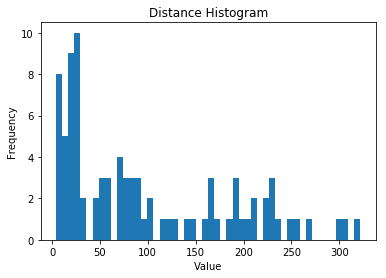

Cutoff length is 23.20298500260939


In [7]:
# choose a cutoff Euclidian distance below which we ignore all edges
# plot histogram of all edge distances 

import matplotlib.pyplot as plt
import numpy as np


fig, ax = plt.subplots(1,1)
distances = [e.straight_length for e in edges]
plt.title("Distance Histogram")
plt.xlabel("Value")
plt.ylabel("Frequency")

b = 50
# ax.hist(distances, bins=50)
ax.hist(distances, bins = b)
plt.show()
ax.set_aspect(1)
y, x, _ = ax.hist(distances, bins = b)

# choose a cutoff edge length where we merge nodes together
cutoff = x[np.argmax(y)]
# print(x[np.argmax(y)])
# print(y.max())
print('Cutoff length is', cutoff)

Now we want to delete all edges of length smaller than the cutoff

In [10]:
# find bad edges and nodes and remove them from the list 



print('Original number of edges and nodes are:',len(edges), len(nodes))
cutoff = 80

bad_edges = [e for e in edges if e.straight_length <= cutoff]


for e in bad_edges:
    for n in nodes:
        if n in e.nodes:
            n.edges.remove(e)
    edges.remove(e)
    
n = len(nodes)
i = 0
while i < n:
    element = nodes[i]
    if not element.edges:
        del nodes[i]
        n = n-1
    else:
        i = i + 1



# for n in nodes_old:
#     if not n.edges:
#         nodes.remove(n)
print('New number of edges and nodes are:',len(edges), len(nodes))

Original number of edges and nodes are: 66 130
New number of edges and nodes are: 40 78


Lets plot it

Text(0.5,1,'Curve fits with removed edges + Original data')

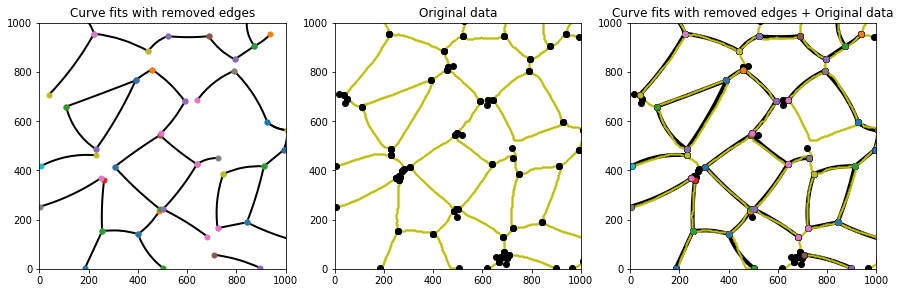

In [11]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
fig, (ax, ax1, ax2) = plt.subplots(1,3, figsize = (15,5))

[n.plot(ax, lw = 2) for n in edges]
[n.plot(ax, markersize = 10) for n in nodes]
ax.set(xlim = [0,1000], ylim = [0,1000], aspect = 1)


for aa in [ax1,ax2]:
    for pos in posit:
        l = len(data1[2][t][pos][:])-1
        # all edges/branches
        aa.plot(data1[1][t][data1[2][t][pos][:],1], data1[1][t][data1[2][t][pos][:],0],'.',color = 'y', markersize = 1)

        # nodes (endpoints)
        aa.plot(data1[1][t][data1[2][t][pos][0],1], data1[1][t][data1[2][t][pos][0],0], 'ok')
        aa.plot(data1[1][t][data1[2][t][pos][l],1], data1[1][t][data1[2][t][pos][l],0], 'ok')
        
[n.plot(ax2, lw = 4) for n in edges]
[n.plot(ax2, markersize = 10) for n in nodes]
ax2.set(xlim = [0,1000], ylim = [0,1000], aspect = 1)
        
ax1.set(xlim = [0,1000], ylim = [0,1000], aspect = 1)
ax1.set_title('Original data')
ax.set_title('Curve fits with removed edges')
ax2.set_title('Curve fits with removed edges + Original data')

Repeat above process till edges look reasonably connected

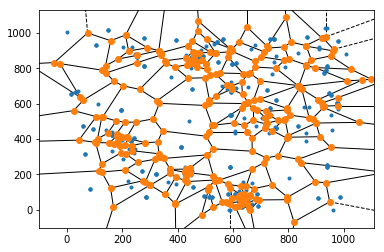

[(0, 1000), (0, 1000)]

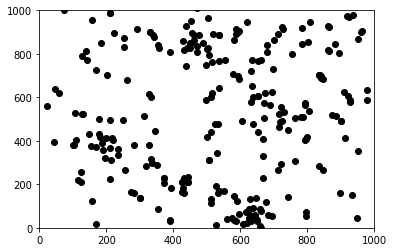

In [57]:
# try voronoi diagram
from scipy.spatial import Voronoi, voronoi_plot_2d
points = []
for n in nodes:
    points.append([n.loc[0],n.loc[1]])
points = np.array(points)



vor = Voronoi(points)
voronoi_plot_2d(vor)
plt.show()

fig, ax = plt.subplots(1,1)

for a in vor.vertices:
    ax.plot(a[0], a[1],'ok')
ax.set(xlim = [0, 1000], ylim = [0,1000])
                

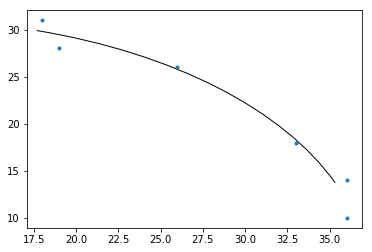

In [54]:
fig, ax = plt.subplots(1,1)
plt.plot(x,y,'.')
patch = matplotlib.patches.Arc(center_2, 2*R_2, 2*R_2,
                                           0, theta1, theta2)
ax.add_patch(patch)
plt.show()

In [13]:
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import numpy as np

def arc_patch(center, radius, theta1, theta2, ax=None, resolution=50, **kwargs):
    # make sure ax is not empty
    if ax is None:
        ax = plt.gca()
    # generate the points
    theta = np.linspace(np.radians(theta1), np.radians(theta2), resolution)
    points = np.vstack((radius*np.cos(theta) + center[0], 
                        radius*np.sin(theta) + center[1]))
    # build the polygon and add it to the axes
    poly = mpatches.Polygon(points.T, closed=True, **kwargs)
    ax.add_patch(poly)
    return poly

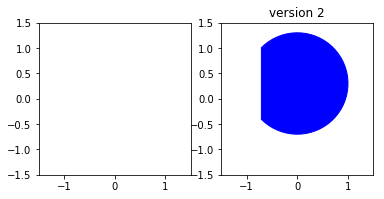

In [21]:
fig, ax = plt.subplots(1,2)

# # @jeanrjc solution, which might hide other objects in your plot
# ax[0].plot([-1,1],[1,-1], 'r', zorder = -10)
# filled_arc((0.,0.3), 1, 90, 180, ax[0], 'blue')
# ax[0].set_title('version 1')

# simpler approach, which really is just the arc
# ax[1].plot([-1,1],[1,-1], 'r', zorder = -10)
arc_patch((0.,0.3), 1, 135, -135, ax=ax[1], fill=True, color='blue')
ax[1].set_title('version 2')

# axis settings
for a in ax:
    a.set_aspect('equal')
    a.set_xlim(-1.5, 1.5)
    a.set_ylim(-1.5, 1.5)

plt.show()

In [61]:
nodes[2].tension_vectors

[[0.9817428999477263, 0.19021271882350219],
 [-0.2545411912268537, 0.9670619328506391]]

In [80]:
edges[0].unit_vectors()

(array([0.2432718 , 0.96995816]), array([-0.5021021 , -0.86480835]))

In [87]:
nodes[1].tension_vectors

[[-0.5021020977164946, -0.8648083507163282],
 [0.9964935206404201, -0.08366996666463299],
 [-0.05260588444114702, 0.9986153518358131]]

In [119]:
a = [np.cos(np.deg2rad(120)), np.sin(np.deg2rad(120))]

In [94]:
b = [np.cos(np.deg2rad(-20)), np.sin(np.deg2rad(-20))]

In [95]:
c = [np.cos(np.deg2rad(-150)), np.sin(np.deg2rad(-150))]

In [116]:
import matplotlib.pyplot as plt
o = [0,0]
a.append(o)

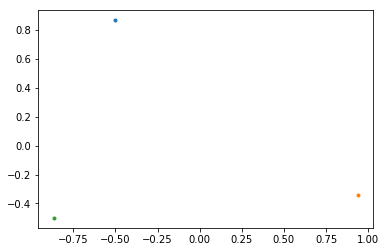

In [125]:
plt.plot(a[0] , a[1],'.' )
plt.plot(b[0], b[1],'.')
plt.plot(c[0], c[1],'.')
plt.show()

In [120]:
a

[-0.4999999999999998, 0.8660254037844388]

In [122]:
np.dot(a, b)

-0.7660444431189779

In [123]:
np.dot(a, c)

-1.6653345369377348e-16

In [10]:
from cell_describe import colony
self = colony(cells)

In [19]:
tensions, A, U, S, V = self.calculate_tension()

In [31]:
# get the list of nodes and edges in the colony
nodes = self.nodes
edges = self.edges

A = np.zeros((len(self.cells), 1))

# of the form tension/radius
rhs = []

for c in self.cells:

    # find cells with a common edge to c
    common_edge_cells = [cell for cell in self.cells if set(c.edges).intersection(set(cell.edges)) != set() if cell != c]

    for cell in common_edge_cells:
        # find common edges between cell and c
        edges = [e for e in set(cell.edges).intersection(set(c.edges))]

        indices = []
        indices.append(self.cells.index(c))
        indices.append(self.cells.index(cell))


        for e in edges:

            temp = np.zeros((len(self.cells),1))
            # we are finding the pressure difference between 2 cells - (cell, c)
            values = np.array([1,-1])
            for j, i in enumerate(indices):
                # here we assign +1 to cell (c) and -1 to cell (cell)
                temp[i] = values[j]

            A = np.append(A, temp, axis=1)

            convex_cell = e.convex_concave(c, cell)
            print(convex_cell)
            print(e.tension)
            if convex_cell == c:
                print(e.tension/e.radius)
                rhs.append(e.tension/ e.radius)
                print(e.radius)
            else:
                print(e.tension/e.radius)
                value =  np.negative(e.tension/ e.radius)
                rhs.append(value)
                

{
 [x:0618, y:0107   ->   x:0778, y:0163]
 [x:0855, y:0362   ->   x:0778, y:0163]
 [x:0855, y:0362   ->   x:0690, y:0371]
 [x:0690, y:0371   ->   x:0618, y:0107]
}
[-0.19460099260463418]
[-0.00036215]
537.3431307583259
{
 [x:0618, y:0107   ->   x:0778, y:0163]
 [x:0855, y:0362   ->   x:0778, y:0163]
 [x:0855, y:0362   ->   x:0690, y:0371]
 [x:0690, y:0371   ->   x:0618, y:0107]
}
[-0.06771076055387737]
[-0.00014769]
458.4709047152761
{
 [x:0423, y:0192   ->   x:0232, y:0326]
 [x:0423, y:0192   ->   x:0597, y:0411]
 [x:0395, y:0463   ->   x:0597, y:0411]
 [x:0395, y:0463   ->   x:0232, y:0326]
}
[0.4324739392995137]
[0.00015545]
{
 [x:0423, y:0192   ->   x:0232, y:0326]
 [x:0423, y:0192   ->   x:0597, y:0411]
 [x:0395, y:0463   ->   x:0597, y:0411]
 [x:0395, y:0463   ->   x:0232, y:0326]
}
[0.4324739392995137]
[0.00015545]
2782.150933779611
{
 [x:0423, y:0192   ->   x:0232, y:0326]
 [x:0423, y:0192   ->   x:0597, y:0411]
 [x:0395, y:0463   ->   x:0597, y:0411]
 [x:0395, y:0463   ->   x:

In [13]:
edge1 = [e for e in cells[0].edges if e.node_a == edges[0].node_a or e.node_b == edges[1].node_a]

IndexError: list index out of range

In [14]:
cells[0].edges

In [19]:
edges

In [12]:
a = []
a.append(-1/3)

In [14]:
np.shape(B)

(34, 11)

In [15]:
np.shape(rhs)

(34,)

In [16]:
U, S, V = np.linalg.svd(B)

In [19]:
np.shape(S)

(11,)

In [20]:
S

array([3.85155193e+00, 3.47291229e+00, 3.18449943e+00, 2.85050905e+00,
       2.53277910e+00, 2.44948974e+00, 2.24698831e+00, 1.64670976e+00,
       1.22917553e+00, 1.07309718e+00, 4.39984109e-16])

In [25]:
pinv_svd = np.dot(np.dot(V.T,np.linalg.inv(np.diag(S))),U.T)

ValueError: shapes (11,11) and (34,34) not aligned: 11 (dim 1) != 34 (dim 0)

In [27]:
np.shape(np.linalg.inv(np.diag(S)))

(11, 11)

In [30]:
np.shape(U.T)

(34, 34)

In [31]:
np.shape(np.dot(V.T,np.linalg.inv(np.diag(S))))

(11, 11)

In [33]:
 np.shape(np.linalg.pinv(B))

(11, 34)

In [35]:
f = np.dot(np.linalg.pinv(B), rhs)

In [37]:
f[1]

-0.0001851971962769716